# 前準備

In [1]:
!pip install linearmodels

You should consider upgrading via the '/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import hashlib

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt


from tqdm import tqdm
from scipy import stats

URL_LENTA_DATA = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv'
URL_CLUSTER_TRIAL = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_cluster_trial.csv'
URL_STRATIFIED_TRIAL = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_stratified_trial.csv'
URL_AATEST = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_aatest_trial.csv'
URL_NONCOMPLIANCE = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_noncompliance_abtest.csv'

# A/Bテストについての発展的な話題

## A/Aテスト：A/Bテスト設計の妥当性を確認する
### A/Bテストは頻繁に「失敗」する

In [2]:
df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


In [3]:
result = smf.ols("is_click ~ is_treatment", data=df_cluster_trial).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.594
Date:                Sun, 24 Sep 2023   Prob (F-statistic):             0.0180
Time:                        19:24:44   Log-Likelihood:                -7718.2
No. Observations:               10640   AIC:                         1.544e+04
Df Residuals:                   10638   BIC:                         1.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5216      0.008     69.521      0.000       0.507       0.536
is_treatment    -0.0232      0.010     -2.365      0.018      -0.043      -0.004
==============================================================================
Omnibus:                    36644.980   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1769.607
Skew:                          -0.032   Prob(JB):                         0.00
Kurtosis:                       1.003   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### A/Aテストをやってみる

In [4]:
# 読み込み
df_aatest = pd.read_csv(URL_AATEST)
df_aatest

,uid,is_treatment,is_click
0,0,1,0
1,1,1,0
2,2,1,1
3,3,0,1
4,4,0,1
...,...,...,...
9995,9995,1,1
9996,9996,1,1
9997,9997,0,1
9998,9998,1,0


In [5]:
# A/Aテストの分析
result = smf.ols("is_click ~ is_treatment", data =df_aatest).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4988,0.007,70.327,0.000,0.485,0.513
is_treatment,0.0102,0.010,1.015,0.310,-0.009,0.030


### 例：A/Aテストのリプレイ(成功ケース)

In [6]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_aatest['is_treatment_in_aa'] = df_aatest['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_aatest).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.71it/s]


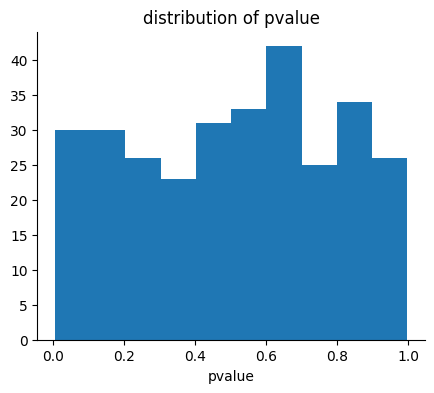

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [8]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.04413487466257898, pvalue=0.5872365643652379, statistic_location=0.5274682079959123, statistic_sign=-1)

## 状況に応じたA/Bテストのモデリング

### クラスターA/BテストCluster A/B Test 

#### クラスターA/BテストデータにおけるA/Aテストのリプレー(失敗ケース)

In [9]:
df_cluster = pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


In [10]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.64it/s]


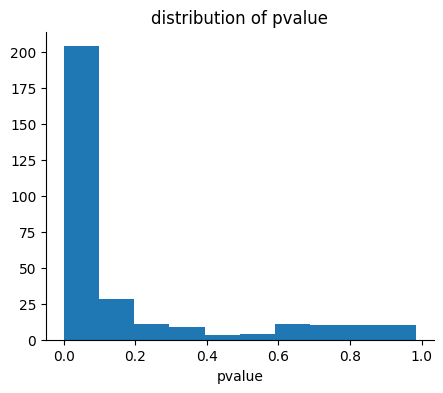

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [12]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.5940350827267781, pvalue=1.5923843685272902e-101, statistic_location=0.11596491727322192, statistic_sign=1)

#### クラスターA/Bテストの実装

- データの読み込み

In [13]:
# データの読み込み
df_cluster_trial= pd.read_csv(URL_CLUSTER_TRIAL)
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


- 分散を補正する

In [14]:
# 分散を補正して推定
result = smf.ols("is_click ~ is_treatment", data=df_cluster).fit()
result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
result_correted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.2906
Date:                Sun, 24 Sep 2023   Prob (F-statistic):              0.590
Time:                        19:25:17   Log-Likelihood:                -7718.2
No. Observations:               10640   AIC:                         1.544e+04
Df Residuals:                   10638   BIC:                         1.546e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5216      0.033     15.632      0.000       0.456       0.587
is_treatment    -0.0232      0.043     -0.539      0.590      -0.108       0.062
==============================================================================
Omnibus:                    36644.980   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1769.607
Skew:                          -0.032   Prob(JB):                         0.00
Kurtosis:                       1.003   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

#### クラスターA/BテストデータにおけるA/Aテストのリプレー(成功ケース)

In [15]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
    pvalue = result_correted.pvalues[result_correted.model.exog_names.index('is_treatment_in_aa')]
    # 情報の格納
    replays.append(pvalue)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.23it/s]


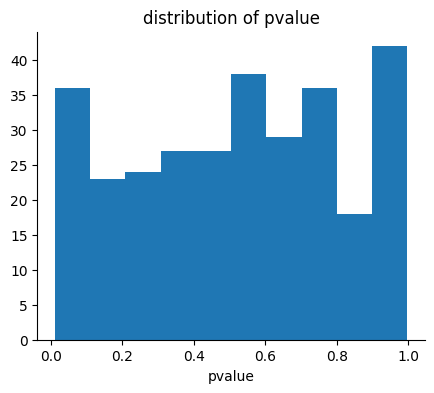

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [17]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.05899866564664091, pvalue=0.237770780294283, statistic_location=0.49233199897997426, statistic_sign=-1)

### 層化A/Bテスト Stratified A/B Test

#### バランステスト失敗するパターン

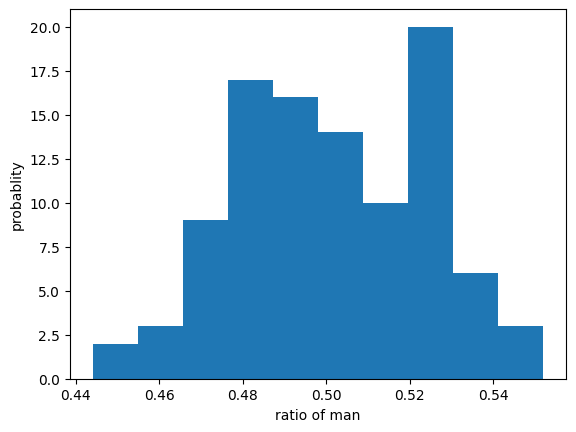

In [18]:
ratio = [np.random.choice([0, 1], p = [0.5, 0.5], size = 500).mean() for _ in range(100)]
plt.hist(ratio)
plt.xlabel('ratio of man')
plt.ylabel('probablity')
plt.show()

#### 層化A/Bテストの割当の実装

In [19]:
df_titanic = sns.load_dataset('titanic')[['survived', 'sex', 'age', 'pclass']]
df_titanic

,survived,sex,age,pclass
0,0,male,22.0,3
1,1,female,38.0,1
2,1,female,26.0,3
3,1,female,35.0,1
4,0,male,35.0,3
...,...,...,...,...
886,0,male,27.0,2
887,1,female,19.0,1
888,0,female,NaN,3
889,1,male,26.0,1


In [20]:
# グループごとに無作為抽出による割当を行う関数
def stratified_assiginment(df_group: pd.DataFrame, ratio_treat: float, rng: np.random.Generator, column_name = 'is_treat',):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(df_group.index, num_samples, replace=False)
    df_group.loc[treat_indices, column_name] = 1
    return df_group

# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = df_titanic.groupby(['sex', 'pclass'], group_keys=False).apply(stratified_assiginment, ratio_treat = 0.3, column_name = 'is_treat', rng = rng)

In [21]:
df_titanic_assigned

,survived,sex,age,pclass,is_treat
0,0,male,22.0,3,0
1,1,female,38.0,1,0
2,1,female,26.0,3,1
3,1,female,35.0,1,0
4,0,male,35.0,3,0
...,...,...,...,...,...
886,0,male,27.0,2,1
887,1,female,19.0,1,0
888,0,female,NaN,3,0
889,1,male,26.0,1,0


In [22]:
df_titanic_assigned.groupby(['sex', 'pclass'])['is_treat'].mean()

sex     pclass
female  1         0.297872
        2         0.302632
        3         0.298611
male    1         0.303279
        2         0.296296
        3         0.299712
Name: is_treat, dtype: float64

#### 層化A/Bテストの分析の実装

- データの読み込み

In [3]:
df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
df_stratified

,is_treatment,group_name,y
0,1,0,-5.166615
1,0,0,-6.641471
2,1,0,-2.885075
3,1,0,-4.307144
4,0,0,-4.115966
...,...,...,...
99,0,1,5.129373
100,1,1,5.164918
101,1,1,4.022947
102,0,1,5.027952


- グループごとの平均的なアウトカム

In [4]:
df_stratified.groupby(['group_name', 'is_treatment']).mean()

y
group_name is_treatment          
0          0            -5.486896
           1            -4.577039
1          0             4.242082
           1             4.288309

- 通常の回帰分析

In [5]:
result = smf.ols("y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.6942,0.601,-2.817,0.006,-2.887,-0.501
is_treatment,-0.1247,0.914,-0.136,0.892,-1.938,1.689


- グループダミーを追加する

In [6]:
result = smf.ols("y ~ is_treatment + C(group_name)", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.3498,0.148,-36.252,0.000,-5.643,-5.057
C(group_name)[T.1],9.3772,0.198,47.266,0.000,8.984,9.771
is_treatment,0.6135,0.192,3.200,0.002,0.233,0.994


## 処置と割当の不一致 A/B テストにおける Non-compliance

- データのimport

In [27]:
# データの読み込み
df_noncompliance= pd.read_csv(URL_NONCOMPLIANCE)
df_noncompliance

,assignment,x,is_deliver,purchase
0,1.0,0.143069,1.0,12272.717011
1,1.0,0.019232,1.0,11289.104060
2,1.0,0.006487,1.0,9130.497979
3,0.0,0.129664,0.0,10276.942082
4,0.0,0.000423,0.0,10131.093488
...,...,...,...,...
995,1.0,-0.114975,0.0,9613.864469
996,0.0,0.066775,0.0,11455.559740
997,0.0,0.083205,0.0,10423.608120
998,0.0,0.160481,0.0,11903.856890


#### Intent to treatな分析

In [28]:
# intent to treatの分析
result = smf.ols("purchase ~ assignment", data=df_noncompliance).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9996.7694,63.888,156.474,0.000,9871.400,1.01e+04
assignment,185.8228,87.183,2.131,0.033,14.740,356.905


In [29]:
df_noncompliance.groupby('assignment')['is_deliver'].mean()

assignment
0.0    0.000000
1.0    0.487896
Name: is_deliver, dtype: float64

####  LATEの導出によるnon-complianceへの対処

In [30]:
iv = IV2SLS.from_formula("purchase ~ 1 + [is_deliver ~ assignment] + x", df_noncompliance).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9997.8,43.469,230.00,0.0000,9912.6,1.008e+04
x,9527.1,306.24,31.110,0.0000,8926.9,1.013e+04
is_deliver,583.91,124.77,4.6799,0.0000,339.37,828.46


- first stage確認

In [31]:
iv.first_stage

,is_deliver
R-squared,0.3129
Partial R-squared,0.3109
Shea's R-squared,0.3109
Partial F-statistic,521.27
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,4.106e-05
,(0.0244)
x,0.3684


# 共変量を入れて分析をする

In [32]:
# サブサンプル分割
df_abtest = pd.read_csv(URL_LENTA_DATA)
df_abtest

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.0000,33.0,1
1,0,0,0.0000,63.0,1
2,1,0,0.0000,51.0,1
3,0,0,0.0000,38.0,1
4,1,0,0.5105,20.0,1
...,...,...,...,...,...
49995,1,0,0.0000,60.0,1
49996,0,0,0.0000,26.0,0
49997,1,0,0.8461,28.0,1
49998,1,0,0.0000,19.0,1


In [33]:
result_with_covariates = smf.ols("response_att ~ is_treatment + food_share_15d + age + is_women", data=df_abtest).fit()
result_with_covariates.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0539,0.005,10.555,0.000,0.044,0.064
is_treatment,0.0072,0.003,2.285,0.022,0.001,0.013
food_share_15d,0.1713,0.003,51.131,0.000,0.165,0.178
age,-0.0003,9.3e-05,-3.047,0.002,-0.000,-0.000
is_women,0.0033,0.003,1.157,0.247,-0.002,0.009


- A/Bテストの結果再掲

In [34]:
result_plain = smf.ols("response_att ~ is_treatment ", data=df_abtest).fit()
result_plain.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1024,0.003,36.412,0.000,0.097,0.108
is_treatment,0.0091,0.003,2.809,0.005,0.003,0.015


# 施策効果の異質性 ~ どこで効果があるのか知る

## セグメントごとにサブサンプルに分割する

In [36]:
# サブサンプル分割
df_men = df_abtest.loc[df_abtest['is_women'] == 0, :]
df_women = df_abtest.loc[df_abtest['is_women'] == 1, :]

In [37]:
# 推定（is_women = 0）
result_men = smf.ols("response_att ~ is_treatment", data=df_men).fit()
result_men.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.021,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.543,0.011,0.003,0.024


In [38]:
# 推定（is_women = 1）
result_women = smf.ols("response_att ~ is_treatment", data=df_women).fit()
result_women.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.004,29.006,0.000,0.096,0.110
is_treatment,0.0065,0.004,1.583,0.113,-0.002,0.014


In [39]:
# 推定した結果をまとめて表示
summary_col([result_men, result_women], model_names=('only men model', 'only women model'), stars=True)

,only men model,only women model
Intercept,0.1010***,0.1032***
,(0.0046),(0.0036)
is_treatment,0.0135**,0.0065
,(0.0053),(0.0041)
R-squared,0.0003,0.0001
R-squared Adj.,0.0003,0.0000


## セグメントの交差項を入れて分析を行う

In [40]:
# ダミー変数であるis_womenカラムの中身を確認する
df_abtest[['is_women']]

,is_women
0,1
1,1
2,1
3,1
4,1
...,...
49995,1
49996,0
49997,1
49998,1


In [41]:
# 推定
result_hetero = smf.ols("response_att ~ is_treatment + is_women + is_treatment * is_women", data=df_abtest).fit()
# 推定結果の表示
result_hetero.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.184,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.562,0.010,0.003,0.024
is_women,0.0022,0.006,0.380,0.704,-0.009,0.014
is_treatment:is_women,-0.0070,0.007,-1.050,0.294,-0.020,0.006
